In [1]:
import re, io
import os, json
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from data_ingestor import *
from time_series import *

plt.style.use('seaborn')
%matplotlib inline

In [2]:
path_to_json = "/Users/shivamsolanki/Desktop/Study/AI_workflow_coursera/ai-workflow-capstone/cs-train/"
column_dict ={'country': 'country', 'customer_id': 'customer_id',
                       'day': 'day','invoice': 'invoice', 'month': 'month',
                       'total_price': 'price', 'StreamID': 'stream_id',
                        'TimesViewed': 'times_viewed'}
inconsistent_col = ['TimesViewed', 'StreamID', 'total_price']
keys=['country', 'customer_id', 'day', 'invoice', 'month', 'price', 'stream_id', 'times_viewed', 'year']

In [3]:
df_total = read_all_json_files(path_to_json, column_dict, inconsistent_col, keys)
df_clean = maintain_datatype(df_total)
df_clean = drop_non_numeric_invoice(df_clean)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




(815011, 9)


##### Country-wise time series analysis

In [4]:
df_UK = df_clean[df_clean['country']=='United Kingdom']
df_EIRE = df_clean[df_clean['country']=='EIRE']
df_Germany = df_clean[df_clean['country']=='Germany']
df_France = df_clean[df_clean['country']=='France']
df_Norway = df_clean[df_clean['country']=='Norway']
df_Spain = df_clean[df_clean['country']=='Spain']
df_Netherlands = df_clean[df_clean['country']=='Netherlands']
df_Belgium = df_clean[df_clean['country']=='Belgium']
df_Portugal = df_clean[df_clean['country']=='Portugal']
df_Switzerland = df_clean[df_clean['country']=='Switzerland']

##### 1. UK

In [5]:
df_day_UK = df_UK.groupby(['year', 'month', 'day']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first',}).reset_index()
df_day_UK = create_date_col(df_day_UK)
df_day_UK = df_day_UK[df_day_UK['price']<=20000]
df_day_UK.head()

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,year,month,day,times_viewed,price,country,Date
0,2017,11,28,12739,12836.40,United Kingdom,2017-11-28
1,2017,11,29,13628,13059.15,United Kingdom,2017-11-29
2,2017,11,30,15196,10865.20,United Kingdom,2017-11-30
3,2017,12,1,11607,9068.60,United Kingdom,2017-12-01
4,2017,12,2,3101,1263.28,United Kingdom,2017-12-02


In [6]:
ts_UK = df_day_UK[['price', 'Date']].set_index('Date') # Set Date as index
ts_UK = ts_UK['price']

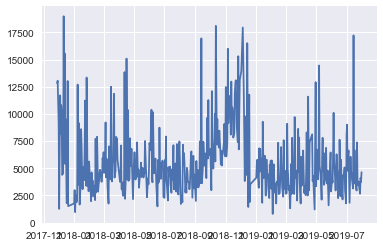

In [7]:
plt.plot(ts_UK)


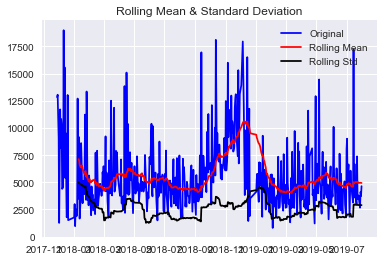

Results of Dickey-Fuller Test:
Test Statistic                  -4.127851
p-value                          0.000871
#Lags Used                       6.000000
Number of Observations Used    479.000000
Critical Value (1%)             -3.444076
Critical Value (5%)             -2.867593
Critical Value (10%)            -2.569994
dtype: float64


In [8]:
test_stationarity(ts_UK)

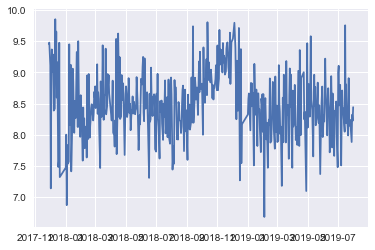

In [9]:
ts_log_UK = np.log(ts_UK)
plt.plot(ts_log_UK)

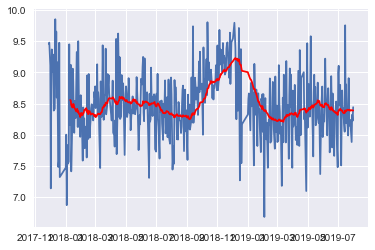

In [10]:
moving_avg_UK = ts_log_UK.rolling(30).mean()
plt.plot(ts_log_UK)
plt.plot(moving_avg_UK, color='red')

In [11]:
ts_log_moving_avg_diff_UK = ts_log_UK - moving_avg_UK


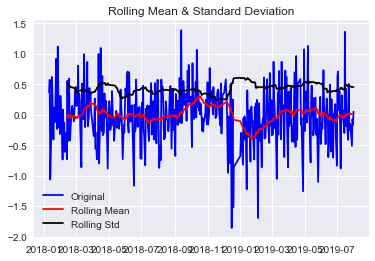

Results of Dickey-Fuller Test:
Test Statistic                -5.843715e+00
p-value                        3.725692e-07
#Lags Used                     5.000000e+00
Number of Observations Used    4.510000e+02
Critical Value (1%)           -3.444933e+00
Critical Value (5%)           -2.867970e+00
Critical Value (10%)          -2.570195e+00
dtype: float64


In [12]:
ts_log_moving_avg_diff_UK.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff_UK)

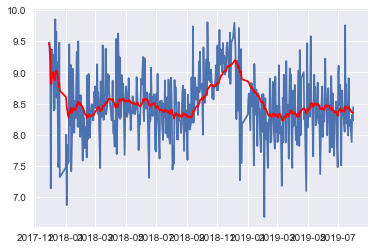

In [13]:
expwighted_avg_UK = ts_log_UK.ewm(halflife=12).mean()
plt.plot(ts_log_UK)
plt.plot(expwighted_avg_UK, color='red')

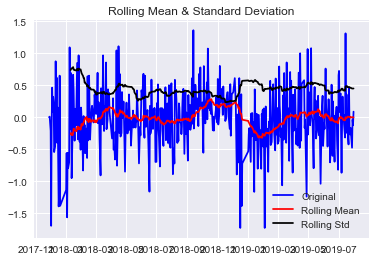

Results of Dickey-Fuller Test:
Test Statistic                -6.433599e+00
p-value                        1.673874e-08
#Lags Used                     5.000000e+00
Number of Observations Used    4.800000e+02
Critical Value (1%)           -3.444047e+00
Critical Value (5%)           -2.867580e+00
Critical Value (10%)          -2.569987e+00
dtype: float64


In [14]:
ts_log_ewma_diff_UK = ts_log_UK - expwighted_avg_UK
test_stationarity(ts_log_ewma_diff_UK)

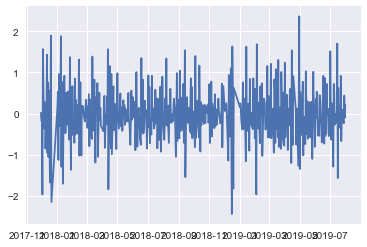

In [15]:
ts_log_diff_UK = ts_log_UK - ts_log_UK.shift()
plt.plot(ts_log_diff_UK)

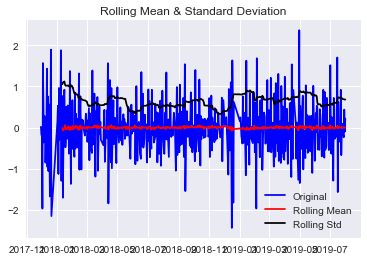

Results of Dickey-Fuller Test:
Test Statistic                -8.221835e+00
p-value                        6.398774e-13
#Lags Used                     1.600000e+01
Number of Observations Used    4.680000e+02
Critical Value (1%)           -3.444400e+00
Critical Value (5%)           -2.867736e+00
Critical Value (10%)          -2.570070e+00
dtype: float64


In [16]:
ts_log_diff_UK.dropna(inplace=True)
test_stationarity(ts_log_diff_UK)

In [17]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



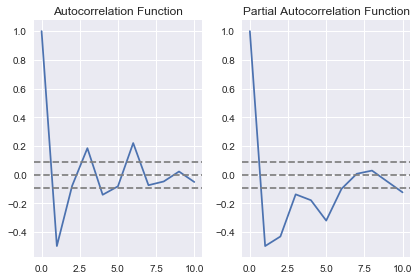

In [18]:
lag_acf = acf(ts_log_diff_UK, nlags=10)
lag_pacf = pacf(ts_log_diff_UK, nlags=10, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff_UK)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff_UK)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff_UK)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff_UK)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [19]:
ts_log_UK = np.log(ts_UK)
ts_log_diff_UK = ts_log_UK - ts_log_UK.shift()
ts_log_diff_UK.dropna(inplace=True)

In [20]:
from statsmodels.tsa.arima_model import ARIMA


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/usr/local/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the fu

Text(0.5, 1.0, 'RSS: nan')

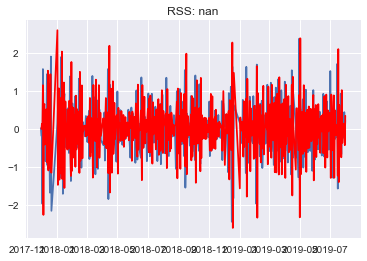

In [21]:
model_UK = ARIMA(ts_log_diff_UK, order=(1, 1, 0))  
results_AR_UK = model_UK.fit(disp=-1)  
plt.plot(ts_log_diff_UK)
plt.plot(results_AR_UK.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR_UK.fittedvalues-ts_log_diff_UK)**2))

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Text(0.5, 1.0, 'RSS: 117.2059')

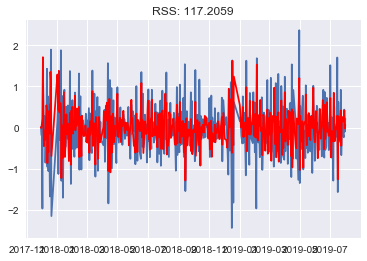

In [22]:
model_UK = ARIMA(ts_log_UK, order=(0, 1, 1))  
results_MA_UK = model_UK.fit(disp=-1)  
plt.plot(ts_log_diff_UK)
plt.plot(results_MA_UK.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA_UK.fittedvalues-ts_log_diff_UK)**2))

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Text(0.5, 1.0, 'RSS: 116.6898')

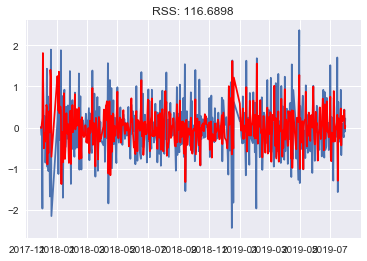

In [35]:
model_UK = ARIMA(ts_log_UK, order=(2, 1, 1))  
results_ARIMA_UK = model_UK.fit(disp=-1)  
plt.plot(ts_log_diff_UK)
plt.plot(results_ARIMA_UK.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_UK.fittedvalues-ts_log_diff_UK)**2))

Text(0.5, 1.0, 'RMSE: 3119485.1327')

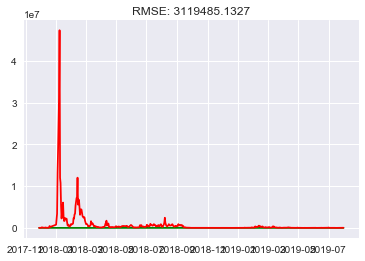

In [36]:
predictions_ARIMA_diff_UK = pd.Series(results_ARIMA_UK.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum_UK = predictions_ARIMA_diff_UK.cumsum()
predictions_ARIMA_log_UK = pd.Series(ts_log_UK.iloc[0], index=ts_log_UK.index)
predictions_ARIMA_log_UK = predictions_ARIMA_log_UK.add(predictions_ARIMA_diff_cumsum_UK,fill_value=0)
predictions_ARIMA_UK = np.exp(predictions_ARIMA_log_UK)
plt.plot(ts_UK, color='green')
plt.plot(predictions_ARIMA_UK, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_UK-ts_UK)**2)/len(ts_UK)))

#### Prophet

In [38]:
from fbprophet import Prophet
m_UK = Prophet()
ts_UK = make_continuous(df_day_UK)
df_UK = pd.DataFrame()
df_UK['ds'] = ts_UK.index
df_UK['y'] = ts_UK.price.values
m_UK.fit(df_UK)
future_UK = m_UK.make_future_dataframe(periods=30)
future_UK.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
636,2019-08-26
637,2019-08-27
638,2019-08-28
639,2019-08-29
640,2019-08-30


In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m_UK, initial='500 days', period='150 days', horizon = '100 days')
df_cv.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-11-28,4962.0,1922.0,9588.0,4962.0,4962.0,824.0,824.0,824.0,824.0,824.0,824.0,0.0,0.0,0.0,5786.0
1,2017-11-29,4965.0,1506.0,8560.0,4965.0,4965.0,30.0,30.0,30.0,30.0,30.0,30.0,0.0,0.0,0.0,4995.0
2,2017-11-30,4967.0,2160.0,9444.0,4967.0,4967.0,791.0,791.0,791.0,791.0,791.0,791.0,0.0,0.0,0.0,5759.0
3,2017-12-01,4970.0,1235.0,8431.0,4970.0,4970.0,-53.0,-53.0,-53.0,-53.0,-53.0,-53.0,0.0,0.0,0.0,4918.0
4,2017-12-02,4973.0,435.0,7689.0,4973.0,4973.0,-994.0,-994.0,-994.0,-994.0,-994.0,-994.0,0.0,0.0,0.0,3979.0
5,2017-12-03,4975.0,-475.0,6638.0,4975.0,4975.0,-1791.0,-1791.0,-1791.0,-1791.0,-1791.0,-1791.0,0.0,0.0,0.0,3185.0
6,2017-12-04,4978.0,2256.0,9490.0,4978.0,4978.0,1192.0,1192.0,1192.0,1192.0,1192.0,1192.0,0.0,0.0,0.0,6170.0
7,2017-12-05,4981.0,2469.0,9438.0,4981.0,4981.0,824.0,824.0,824.0,824.0,824.0,824.0,0.0,0.0,0.0,5804.0
8,2017-12-06,4983.0,1274.0,8595.0,4983.0,4983.0,30.0,30.0,30.0,30.0,30.0,30.0,0.0,0.0,0.0,5013.0
9,2017-12-07,4986.0,2072.0,9041.0,4986.0,4986.0,791.0,791.0,791.0,791.0,791.0,791.0,0.0,0.0,0.0,5777.0


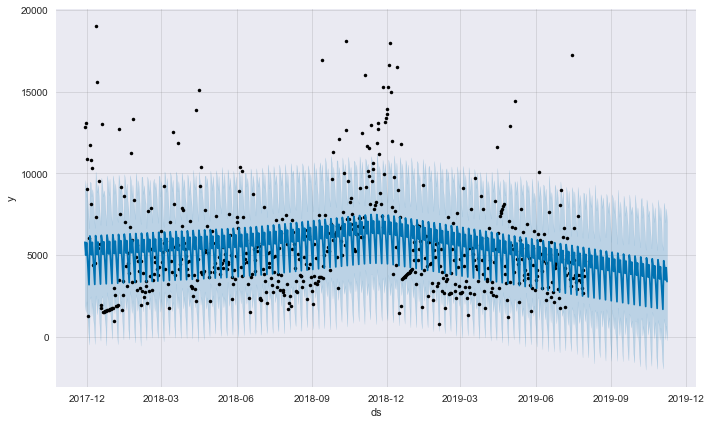

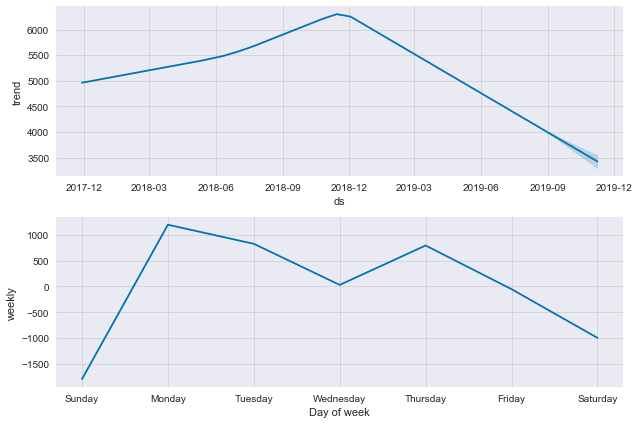

In [39]:
prophet_forecast(df_day_UK, 100)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


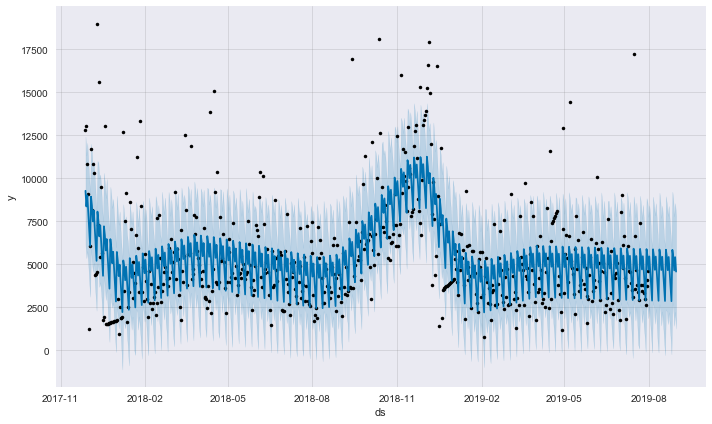

In [14]:
ts_UK = make_continuous(df_day_UK)
df_UK = pd.DataFrame()
df_UK['ds'] = ts_UK.index
df_UK['y'] = ts_UK.price.values
m2 = Prophet(changepoint_prior_scale=0.8)
m_UK = m2.fit(df_UK)
future = m2.make_future_dataframe(periods = 30)
forecast = m_UK.predict(future)
fig = m2.plot(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-11-28,7813.0,5708.0,11698.0,7813.0,7813.0,807.0,807.0,807.0,807.0,807.0,807.0,0.0,0.0,0.0,8619.0
1,2017-11-29,7725.0,4697.0,10823.0,7725.0,7725.0,17.0,17.0,17.0,17.0,17.0,17.0,0.0,0.0,0.0,7742.0
2,2017-11-30,7637.0,5311.0,11522.0,7637.0,7637.0,789.0,789.0,789.0,789.0,789.0,789.0,0.0,0.0,0.0,8426.0
3,2017-12-01,7549.0,4510.0,10807.0,7549.0,7549.0,-50.0,-50.0,-50.0,-50.0,-50.0,-50.0,0.0,0.0,0.0,7499.0
4,2017-12-02,7461.0,3179.0,9587.0,7461.0,7461.0,-987.0,-987.0,-987.0,-987.0,-987.0,-987.0,0.0,0.0,0.0,6474.0
5,2017-12-03,7373.0,2620.0,8743.0,7373.0,7373.0,-1780.0,-1780.0,-1780.0,-1780.0,-1780.0,-1780.0,0.0,0.0,0.0,5593.0
6,2017-12-04,7285.0,5496.0,11753.0,7285.0,7285.0,1204.0,1204.0,1204.0,1204.0,1204.0,1204.0,0.0,0.0,0.0,8489.0
7,2017-12-05,7197.0,4967.0,11133.0,7197.0,7197.0,807.0,807.0,807.0,807.0,807.0,807.0,0.0,0.0,0.0,8004.0
8,2017-12-06,7109.0,3963.0,10352.0,7109.0,7109.0,17.0,17.0,17.0,17.0,17.0,17.0,0.0,0.0,0.0,7127.0
9,2017-12-07,7022.0,4589.0,10747.0,7022.0,7022.0,789.0,789.0,789.0,789.0,789.0,789.0,0.0,0.0,0.0,7811.0


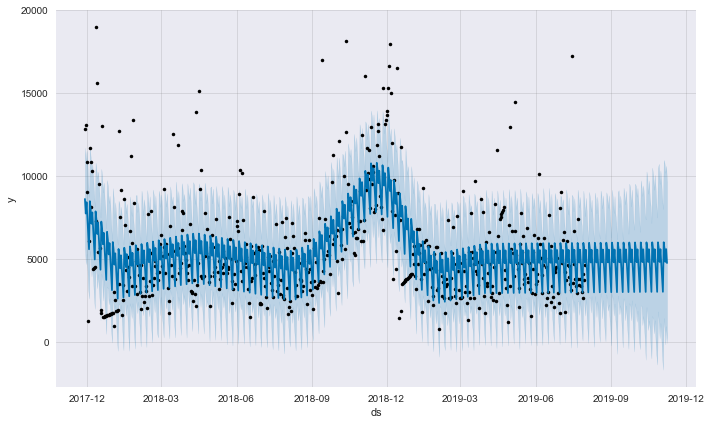

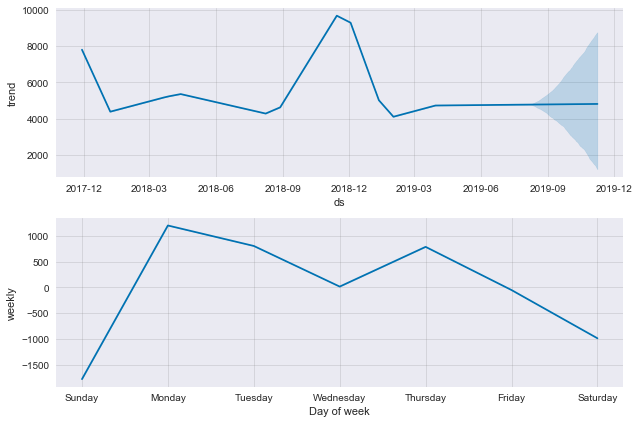

In [7]:
prophet_forecast(df_day_UK, 100, 0.5)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-11-28,8479.0,6263.0,12507.0,8479.0,8479.0,803.0,803.0,803.0,803.0,803.0,803.0,0.0,0.0,0.0,9282.0
1,2017-11-29,8354.0,5173.0,11494.0,8354.0,8354.0,15.0,15.0,15.0,15.0,15.0,15.0,0.0,0.0,0.0,8370.0
2,2017-11-30,8230.0,5841.0,12282.0,8230.0,8230.0,788.0,788.0,788.0,788.0,788.0,788.0,0.0,0.0,0.0,9018.0
3,2017-12-01,8106.0,4992.0,11065.0,8106.0,8106.0,-50.0,-50.0,-50.0,-50.0,-50.0,-50.0,0.0,0.0,0.0,8056.0
4,2017-12-02,7982.0,4043.0,9921.0,7982.0,7982.0,-986.0,-986.0,-986.0,-986.0,-986.0,-986.0,0.0,0.0,0.0,6996.0
5,2017-12-03,7858.0,3055.0,9171.0,7858.0,7858.0,-1778.0,-1778.0,-1778.0,-1778.0,-1778.0,-1778.0,0.0,0.0,0.0,6080.0
6,2017-12-04,7733.0,5996.0,11822.0,7733.0,7733.0,1207.0,1207.0,1207.0,1207.0,1207.0,1207.0,0.0,0.0,0.0,8940.0
7,2017-12-05,7609.0,5311.0,11600.0,7609.0,7609.0,803.0,803.0,803.0,803.0,803.0,803.0,0.0,0.0,0.0,8413.0
8,2017-12-06,7485.0,4737.0,10412.0,7485.0,7485.0,15.0,15.0,15.0,15.0,15.0,15.0,0.0,0.0,0.0,7500.0
9,2017-12-07,7361.0,5018.0,11349.0,7361.0,7361.0,788.0,788.0,788.0,788.0,788.0,788.0,0.0,0.0,0.0,8149.0


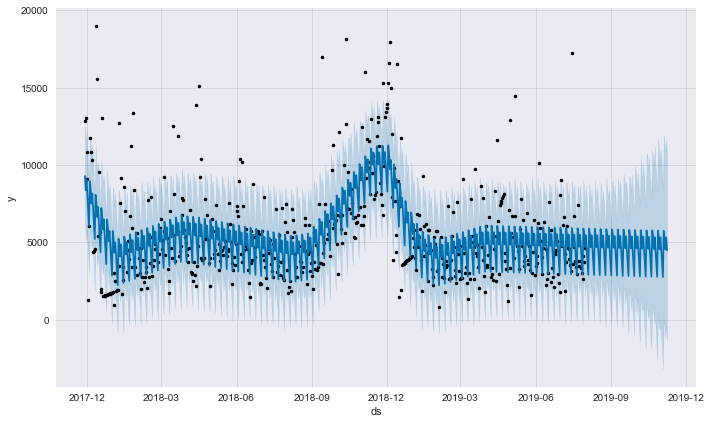

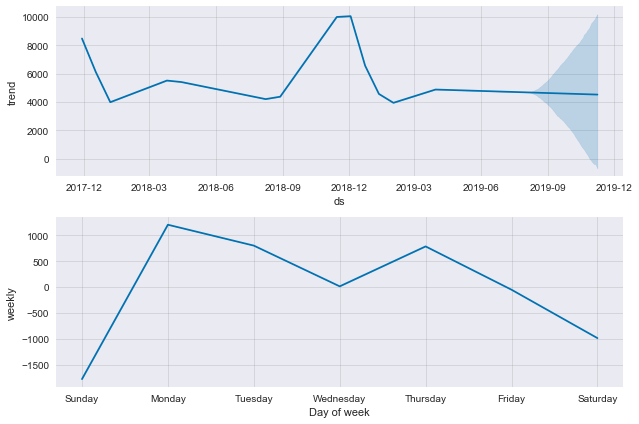

In [8]:
prophet_forecast(df_day_UK, 100, 0.8)